# Imitation Learning for Portfolio Management

In [1]:
from __future__ import print_function

from utils.data import create_optimal_imitation_dataset, create_imitation_dataset, read_stock_history, normalize
import numpy as np
import random
from keras.utils.np_utils import to_categorical

from model.supervised.imitation_optimal_action import create_network_given_future,     train_optimal_action_given_future_obs,create_network_give_past, train_optimal_action_given_history_obs

%load_ext autoreload
%matplotlib inline

#%autoreload 2

Using TensorFlow backend.


In [2]:
# dataset
history, abbreviation = read_stock_history(filepath='utils/datasets/stocks_history_target.h5')
history = history[:, :, :4]


# 16 stocks are all involved. We choose first 3 years as training data and last 2 years as testing data.
num_training_time = 1095
target_stocks = abbreviation
target_history = np.empty(shape=(len(target_stocks), num_training_time, history.shape[2]))

for i, stock in enumerate(target_stocks):
    target_history[i] = history[abbreviation.index(stock), :num_training_time, :]

# test on 3 never seen stocks
test_stocks = abbreviation
test_history = np.empty(shape=(len(test_stocks), history.shape[1] - num_training_time, history.shape[2]))
for i, stock in enumerate(test_stocks):
    test_history[i] = history[abbreviation.index(stock), num_training_time:, :]

## Train optimal action given future observation

### The WINNER model

In [3]:
# build optimal model given future model
nb_classes = len(target_stocks) + 1
optimal_given_future_model = create_network_given_future(nb_classes, True)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Build model from scratch


In [4]:
# run this cell to train optimal action given future model
train_optimal_action_given_future_obs(optimal_given_future_model, target_history, target_stocks,True)

Instructions for updating:
Use tf.cast instead.
Train on 876 samples, validate on 219 samples
Epoch 1/20
876/876 [==============================] - 1s 603us/step - loss: 2.6014 - acc: 0.2078 - val_loss: 2.5154 - val_acc: 0.3105
Epoch 2/20
876/876 [==============================] - 0s 59us/step - loss: 2.0273 - acc: 0.4521 - val_loss: 2.2737 - val_acc: 0.3790
Epoch 3/20
876/876 [==============================] - 0s 56us/step - loss: 1.6691 - acc: 0.5422 - val_loss: 1.9700 - val_acc: 0.4247
Epoch 4/20
876/876 [==============================] - 0s 54us/step - loss: 1.3881 - acc: 0.6301 - val_loss: 1.6782 - val_acc: 0.5023
Epoch 5/20
876/876 [==============================] - 0s 55us/step - loss: 1.2135 - acc: 0.6781 - val_loss: 1.4299 - val_acc: 0.5845
Epoch 6/20
876/876 [==============================] - 0s 58us/step - loss: 1.0287 - acc: 0.7203 - val_loss: 1.2591 - val_acc: 0.5936
Epoch 7/20
876/876 [==============================] - 0s 54us/step - loss: 0.9143 - acc: 0.7466 - val_loss:

### The LOSER model

In [5]:
# build optimal model given future model
loser_given_future_model = create_network_given_future(nb_classes,False)

Build model from scratch


In [6]:
# run this cell to train optimal action given future model
train_optimal_action_given_future_obs(loser_given_future_model, target_history, target_stocks, False)

Train on 876 samples, validate on 219 samples
Epoch 1/20
876/876 [==============================] - 1s 604us/step - loss: 2.5860 - acc: 0.2089 - val_loss: 2.5909 - val_acc: 0.2146
Epoch 2/20
876/876 [==============================] - 0s 55us/step - loss: 2.1128 - acc: 0.3699 - val_loss: 2.3755 - val_acc: 0.2968
Epoch 3/20
876/876 [==============================] - 0s 55us/step - loss: 1.7890 - acc: 0.5000 - val_loss: 2.1209 - val_acc: 0.4110
Epoch 4/20
876/876 [==============================] - 0s 56us/step - loss: 1.5367 - acc: 0.5788 - val_loss: 1.9190 - val_acc: 0.4566
Epoch 5/20
876/876 [==============================] - 0s 56us/step - loss: 1.3371 - acc: 0.6084 - val_loss: 1.7254 - val_acc: 0.5068
Epoch 6/20
876/876 [==============================] - 0s 56us/step - loss: 1.1401 - acc: 0.6747 - val_loss: 1.5480 - val_acc: 0.5114
Epoch 7/20
876/876 [==============================] - 0s 57us/step - loss: 1.0416 - acc: 0.6838 - val_loss: 1.4554 - val_acc: 0.5342
Epoch 8/20
876/876 [==

## Test learning from optimal action using future data: sanity check

### The WINNER model

In [7]:
(X_test, y_test), (_, _) = create_optimal_imitation_dataset(test_history, True)

Y_test = to_categorical(y_test, nb_classes)
loss, acc = optimal_given_future_model.evaluate(X_test, Y_test)
print('Testing result: loss - {}, accuracy - {}'.format(loss, acc))

584/584 [==============================] - 0s 38us/step
Testing result: loss - 0.8146826518725042, accuracy - 0.714041095890411


### The LOSER model

In [8]:
(X_test1, y_test1), (_, _) = create_optimal_imitation_dataset(test_history, False)
Y_test1 = to_categorical(y_test1, nb_classes)
loss1, acc1 = loser_given_future_model.evaluate(X_test1, Y_test1)
print('Testing result: loss - {}, accuracy - {}'.format(loss, acc))

584/584 [==============================] - 0s 38us/step
Testing result: loss - 0.8146826518725042, accuracy - 0.714041095890411


### Start to play in an environment with stocks we have never seen before

In [9]:
from environment.portfolio import PortfolioEnv
env = PortfolioEnv(test_history, test_stocks, steps=365)

### The WINNER model

<Figure size 432x288 with 0 Axes>

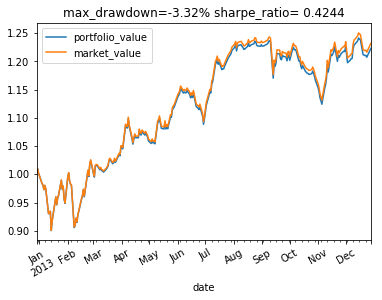

In [10]:
# buy and sell only 1 stock
done = False
observation, info = env.reset()
ground_truth_obs = info['next_obs']
close_open_ratio = np.transpose(ground_truth_obs[:, :, 3] / ground_truth_obs[:, :, 0])
close_open_ratio = normalize(close_open_ratio)
while not done:
    action = np.ones((nb_classes,))
    current_action_index = optimal_given_future_model.predict_classes(close_open_ratio, verbose=False)
    action[current_action_index] = nb_classes -1
    observation, reward, done, info = env.step(action)
    ground_truth_obs = info['next_obs']
    close_open_ratio = np.transpose(ground_truth_obs[:, :, 3] / ground_truth_obs[:, :, 0])
    close_open_ratio = normalize(close_open_ratio)
env.render()

### The LOSER model

<Figure size 432x288 with 0 Axes>

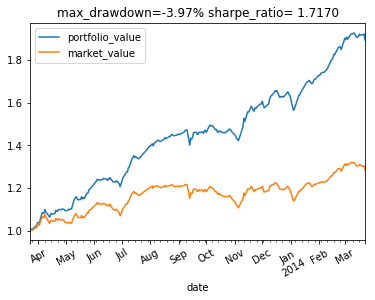

In [11]:
# buy and sell only 1 stock
done = False
observation, info = env.reset()
ground_truth_obs = info['next_obs']
close_open_ratio = np.transpose(ground_truth_obs[:, :, 3] / ground_truth_obs[:, :, 0])
close_open_ratio = normalize(close_open_ratio)
while not done:
    action = np.ones((nb_classes,)) # instead of zeros
    current_action_index = loser_given_future_model.predict_classes(close_open_ratio, verbose=False)
    action[current_action_index] = 0 # instead of 1.0
    observation, reward, done, info = env.step(action)
    ground_truth_obs = info['next_obs']
    close_open_ratio = np.transpose(ground_truth_obs[:, :, 3] / ground_truth_obs[:, :, 0])
    close_open_ratio = normalize(close_open_ratio)
env.render()

### It turns out that using probability distribution sometimes yield higher return

### The WINNER model

<Figure size 432x288 with 0 Axes>

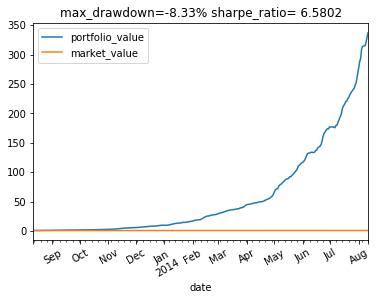

In [12]:
# buy and sell according to the probability, not the label
done = False
observation, info = env.reset()
ground_truth_obs = info['next_obs']
close_open_ratio = np.transpose(ground_truth_obs[:, :, 3] / ground_truth_obs[:, :, 0])
close_open_ratio = normalize(close_open_ratio)
printed=0
while not done:
    current_action = optimal_given_future_model.predict(close_open_ratio, verbose=False)
  
    current_action = np.squeeze(current_action, axis=0)
        
    observation, reward, done, info = env.step(current_action)
    ground_truth_obs = info['next_obs']
    close_open_ratio = np.transpose(ground_truth_obs[:, :, 3] / ground_truth_obs[:, :, 0])
    close_open_ratio = normalize(close_open_ratio)
env.render()

### The LOSER model

<Figure size 432x288 with 0 Axes>

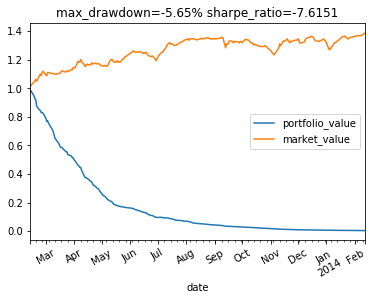

In [13]:
# buy and sell according to the probability, not the label
done = False
observation, info = env.reset()
ground_truth_obs = info['next_obs']
close_open_ratio = np.transpose(ground_truth_obs[:, :, 3] / ground_truth_obs[:, :, 0])
close_open_ratio = normalize(close_open_ratio)
printed=0
while not done:
    current_action = loser_given_future_model.predict(close_open_ratio, verbose=False)
    
    current_action = np.squeeze(current_action, axis=0)
        
    observation, reward, done, info = env.step(current_action)
    ground_truth_obs = info['next_obs']
    close_open_ratio = np.transpose(ground_truth_obs[:, :, 3] / ground_truth_obs[:, :, 0])
    close_open_ratio = normalize(close_open_ratio)
env.render()

## Train optimal action given history observation

### The WINNER model

In [14]:
# we need to test different window length
window_length = 3
# create model
optimal_given_past_model = create_network_give_past(nb_classes, window_length,True)

Build model from scratch


In [15]:
# run this cell to train the model. 
# For 3 stocks, it would take 200 epoches to converge to around 45% validation accuracy
# For 16 stocks, the validation accuracy is around 15%.
train_optimal_action_given_history_obs(optimal_given_past_model, target_history, target_stocks, window_length,True )

Train on 876 samples, validate on 216 samples
Epoch 1/100
876/876 [==============================] - 1s 1ms/step - loss: 2.8908 - acc: 0.0833 - val_loss: 2.8220 - val_acc: 0.1157
Epoch 2/100
876/876 [==============================] - 0s 74us/step - loss: 2.8077 - acc: 0.1119 - val_loss: 2.8156 - val_acc: 0.1065
Epoch 3/100
876/876 [==============================] - 0s 71us/step - loss: 2.7667 - acc: 0.1267 - val_loss: 2.8121 - val_acc: 0.1111
Epoch 4/100
876/876 [==============================] - 0s 68us/step - loss: 2.7662 - acc: 0.1027 - val_loss: 2.8091 - val_acc: 0.1065
Epoch 5/100
876/876 [==============================] - 0s 66us/step - loss: 2.7577 - acc: 0.1233 - val_loss: 2.8065 - val_acc: 0.1065
Epoch 6/100
876/876 [==============================] - 0s 65us/step - loss: 2.7355 - acc: 0.1233 - val_loss: 2.8053 - val_acc: 0.1111
Epoch 7/100
876/876 [==============================] - 0s 65us/step - loss: 2.7207 - acc: 0.1153 - val_loss: 2.8037 - val_acc: 0.1204
Epoch 8/100
876/8

876/876 [==============================] - 0s 66us/step - loss: 2.5473 - acc: 0.1884 - val_loss: 2.7750 - val_acc: 0.1157
Epoch 62/100
876/876 [==============================] - 0s 68us/step - loss: 2.5376 - acc: 0.1781 - val_loss: 2.7749 - val_acc: 0.1250
Epoch 63/100
876/876 [==============================] - 0s 67us/step - loss: 2.5344 - acc: 0.1826 - val_loss: 2.7755 - val_acc: 0.1111
Epoch 64/100
876/876 [==============================] - 0s 66us/step - loss: 2.5478 - acc: 0.1986 - val_loss: 2.7757 - val_acc: 0.1157
Epoch 65/100
876/876 [==============================] - 0s 68us/step - loss: 2.5294 - acc: 0.1906 - val_loss: 2.7760 - val_acc: 0.1204
Epoch 66/100
876/876 [==============================] - 0s 66us/step - loss: 2.5070 - acc: 0.2078 - val_loss: 2.7766 - val_acc: 0.1204
Epoch 67/100
876/876 [==============================] - 0s 68us/step - loss: 2.5091 - acc: 0.2169 - val_loss: 2.7766 - val_acc: 0.1157
Epoch 68/100
876/876 [==============================] - 0s 67us/step

### The LOSER model

In [16]:
# create model
loser_given_past_model = create_network_give_past(nb_classes, window_length,False)

Build model from scratch


In [17]:
train_optimal_action_given_history_obs(loser_given_past_model, target_history, target_stocks, window_length,False)

Train on 876 samples, validate on 216 samples
Epoch 1/100
876/876 [==============================] - 1s 1ms/step - loss: 2.8780 - acc: 0.0822 - val_loss: 2.8223 - val_acc: 0.0787
Epoch 2/100
876/876 [==============================] - 0s 67us/step - loss: 2.8367 - acc: 0.0685 - val_loss: 2.8176 - val_acc: 0.0741
Epoch 3/100
876/876 [==============================] - 0s 69us/step - loss: 2.7805 - acc: 0.0936 - val_loss: 2.8146 - val_acc: 0.0787
Epoch 4/100
876/876 [==============================] - 0s 66us/step - loss: 2.7492 - acc: 0.1107 - val_loss: 2.8113 - val_acc: 0.0833
Epoch 5/100
876/876 [==============================] - 0s 68us/step - loss: 2.7403 - acc: 0.1096 - val_loss: 2.8092 - val_acc: 0.0833
Epoch 6/100
876/876 [==============================] - 0s 67us/step - loss: 2.7289 - acc: 0.1073 - val_loss: 2.8073 - val_acc: 0.0741
Epoch 7/100
876/876 [==============================] - 0s 71us/step - loss: 2.7121 - acc: 0.1279 - val_loss: 2.8051 - val_acc: 0.0833
Epoch 8/100
876/8

876/876 [==============================] - 0s 73us/step - loss: 2.5370 - acc: 0.1872 - val_loss: 2.7796 - val_acc: 0.1620
Epoch 62/100
876/876 [==============================] - 0s 72us/step - loss: 2.5004 - acc: 0.2066 - val_loss: 2.7762 - val_acc: 0.1620
Epoch 63/100
876/876 [==============================] - 0s 69us/step - loss: 2.5212 - acc: 0.2066 - val_loss: 2.7734 - val_acc: 0.1574
Epoch 64/100
876/876 [==============================] - 0s 71us/step - loss: 2.5168 - acc: 0.2123 - val_loss: 2.7716 - val_acc: 0.1574
Epoch 65/100
876/876 [==============================] - 0s 72us/step - loss: 2.5172 - acc: 0.2135 - val_loss: 2.7706 - val_acc: 0.1620
Epoch 66/100
876/876 [==============================] - 0s 72us/step - loss: 2.5105 - acc: 0.1998 - val_loss: 2.7696 - val_acc: 0.1620
Epoch 67/100
876/876 [==============================] - 0s 69us/step - loss: 2.4974 - acc: 0.1963 - val_loss: 2.7713 - val_acc: 0.1574
Epoch 68/100
876/876 [==============================] - 0s 72us/step

## Test optimal action given history observation

### The WINNER model

In [18]:
(X_test, y_test), (_, _) = create_imitation_dataset(test_history, window_length, True)
Y_test = to_categorical(y_test, nb_classes)
# increase a dimension of X_test for CNN
X_test = np.expand_dims(X_test, axis=-1)
loss, acc = optimal_given_past_model.evaluate(X_test, Y_test)
print('Testing result: loss - {}, accuracy - {}'.format(loss, acc))

584/584 [==============================] - 0s 46us/step
Testing result: loss - 2.73698638236686, accuracy - 0.1541095890410959


### The LOSER model

In [19]:
(X_test, y_test), (_, _) = create_imitation_dataset(test_history, window_length, False)
Y_test = to_categorical(y_test, nb_classes)
# increase a dimension of X_test for CNN
X_test = np.expand_dims(X_test, axis=-1)
loss, acc = loser_given_past_model.evaluate(X_test, Y_test)
print('Testing result: loss - {}, accuracy - {}'.format(loss, acc))

584/584 [==============================] - 0s 55us/step
Testing result: loss - 2.8861499681864697, accuracy - 0.08047945205479452


# Backtesting

In [20]:
env = PortfolioEnv(test_history, test_stocks, window_length=window_length, steps=365)

### The WINNER model

<Figure size 432x288 with 0 Axes>

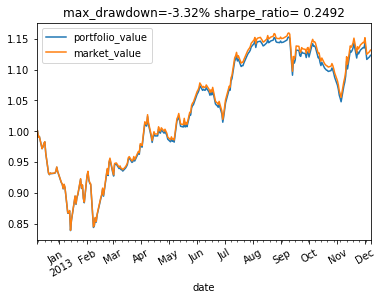

In [21]:
# buy and sell only 1 stock
done = False
observation, _ = env.reset()
close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
close_open_ratio = normalize(close_open_ratio)
while not done:
    action = np.ones((nb_classes,))
    close_open_ratio = np.expand_dims(close_open_ratio, axis=0)
    close_open_ratio = np.expand_dims(close_open_ratio, axis=-1)
    current_action_index = optimal_given_past_model.predict_classes(close_open_ratio, verbose=False )
    action[current_action_index] = nb_classes -1 
    observation, reward, done, _ = env.step(action)
    close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
    close_open_ratio = normalize(close_open_ratio)
env.render()

### The LOSER model

<Figure size 432x288 with 0 Axes>

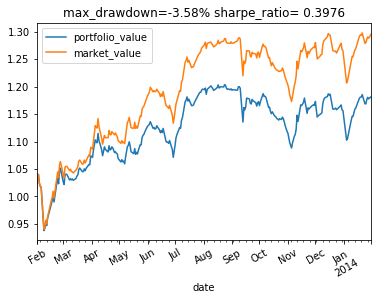

In [22]:
# buy and sell only 1 stock
done = False
observation, _ = env.reset()
close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
close_open_ratio = normalize(close_open_ratio)
while not done:
    action = np.ones((nb_classes,))
    close_open_ratio = np.expand_dims(close_open_ratio, axis=0)
    close_open_ratio = np.expand_dims(close_open_ratio, axis=-1)
    current_action_index = loser_given_past_model.predict_classes(close_open_ratio,True, verbose=False)
    action[current_action_index] = 0.0 #instead of 1.0
    observation, reward, done, _ = env.step(action)
    close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
    close_open_ratio = normalize(close_open_ratio)
env.render()

### The WINNER + LOSER model

<Figure size 432x288 with 0 Axes>

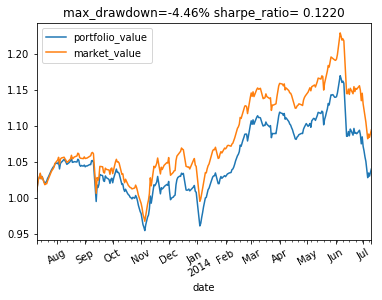

In [23]:
# buy and sell only 1 stock
done = False
observation, _ = env.reset()
close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
close_open_ratio = normalize(close_open_ratio)
while not done:
    close_open_ratio = np.expand_dims(close_open_ratio, axis=0)
    close_open_ratio = np.expand_dims(close_open_ratio, axis=-1)
    
    action = np.ones((nb_classes,))/nb_classes
    current_action_index = optimal_given_past_model.predict_classes(close_open_ratio, verbose=False )
    action[current_action_index] = 1.0/nb_classes * 2
    
    current_action_index = loser_given_past_model.predict_classes(close_open_ratio,True, verbose=False)
    action[current_action_index] = 0.0 #instead of 1.0
    
    observation, reward, done, _ = env.step(action)
    close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
    close_open_ratio = normalize(close_open_ratio)
env.render()

## buy and sell according to the probability, not the label

### The WINNER model

<Figure size 432x288 with 0 Axes>

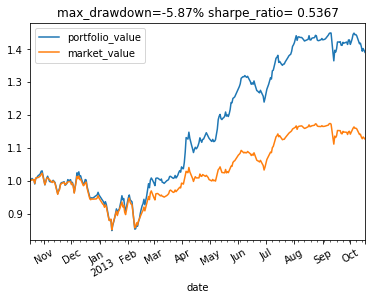

In [24]:

done = False
observation, _ = env.reset()
close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
while not done:
    close_open_ratio = np.expand_dims(close_open_ratio, axis=0)
    close_open_ratio = np.expand_dims(close_open_ratio, axis=-1)
    close_open_ratio = normalize(close_open_ratio)
    current_action = optimal_given_past_model.predict(close_open_ratio,verbose=False)

    current_action = np.squeeze(current_action, axis=0)
    
    observation, reward, done, _ = env.step(current_action)
    close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
env.render()

### The LOSER model

<Figure size 432x288 with 0 Axes>

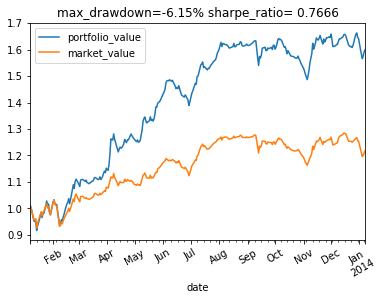

In [25]:
# buy and sell according to the probability, not the label
done = False
observation, _ = env.reset()
close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
while not done:
    close_open_ratio = np.expand_dims(close_open_ratio, axis=0)
    close_open_ratio = np.expand_dims(close_open_ratio, axis=-1)
    close_open_ratio = normalize(close_open_ratio)
    current_action = loser_given_past_model.predict(close_open_ratio,verbose=False)

    current_action = np.squeeze(current_action, axis=0)
    
    observation, reward, done, _ = env.step(current_action)
    close_open_ratio = observation[:, :, 3] / observation[:, :, 0]
env.render()